# 2020-04-30: Continuing segmentation/analysis of lattice MS2 data

I think I have a decent framework for segmenting nuclei in lattice stacks. I spent a lot of time writing weird functions that didn't do much, but I think the framework is good: I built a function which takes a function that segments 3D stacks and a function that connects consecutive 3D stacks. It's extensible — I can keep tinkering with it via the 3D segmentation function. As with anything else, this isn't an end point, but something that works for now and that I've built to be easily expanded/improved upon.

First step: test this segmentation on a few different Bicoid and Zelda stacks to see how it performs.

In [175]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
# from skimage import filters, measure, segmentation, transform, exposure, img_as_ubyte, feature, morphology
#from skimage import filters, io
from functools import partial
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [41]:
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
from imagep import (read_tiff_folder, read_tiff_lattice, viewer, viewer, segment_embryo, labelmask_apply_morphology)
import imagep as imp
reload(imp);


In [3]:
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em5_mv2/',
    span=(0,8))
stack_t3 = stack[:,0:3]

/Users/MStadler/opt/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2135: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [37]:
test = lattice_segment_nuclei_2(stack_t3, dilation_length=7)

1
2


In [32]:
viewer([stack[1], test*30], 'tzxy')

interactive(children=(Dropdown(description='Color', index=6, options=('inferno', 'plasma', 'Reds', 'gray_r', '…

For the Zelda movies:  

20171207_Zldeve_em1_mv1  
20171207_Zldeve_em1_mv2  

Mostly pretty good. Missed a nucleus near the border in both, but seems generally acceptable.

20171207_Zldeve_em5_mv2 gave problems because it's nc14 and the nuclei are too small for the default (I think). So I'll back up and try to segment a single 3D stack, find parameters that work, and then apply those to the stack. This will probably be the workflow in general, so it's good to try it out.



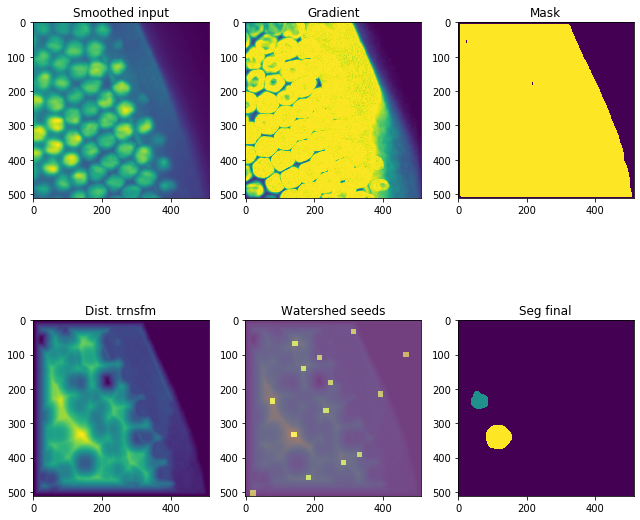

In [52]:
test = imp.segment_nuclei3D_2(stack[1,0], display=True)

In [51]:
test = imp.segment_nuclei3D_1(stack[1,0], percentile=90)
viewer([stack[1,0], test*15], 'zxy')

interactive(children=(Dropdown(description='Color', index=6, options=('inferno', 'plasma', 'Reds', 'gray_r', '…

So we have a problem: segmenter 2 fails when the nuclei touch each other. This could be because the morphological closing step of the thresholded image closes all the gaps between nuclei. I commented it out and tried again:

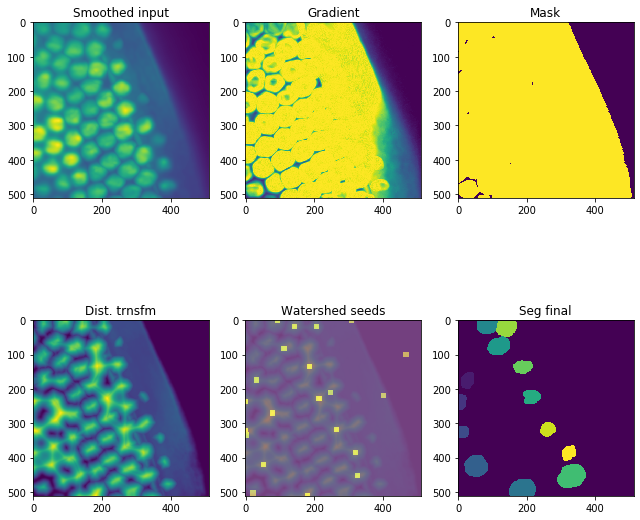

In [54]:
# Removed closing of mask.
test = imp.segment_nuclei3D_2(stack[1,0], display=True)

This is much better, but still pretty bad. An interesting observation is that the straight thresholding approach of algorithm 1 does pretty well at just finding nuclei, but I got away from it because it had issues (thresholding just isn't a good way to find edges). So I wonder about making a third algorithm that combines the two:

1. Threshold (as in 1) to get a crude mask of nuclei, aiming to get less-than complete coverage of the nucleus (since it's just for watershed seed finding).
2. Use distance transform and local max on this mask to make watershed seeds.
3. Watershed (as in 2) on the gradient.

This could be a useful thing. It also occurred to me that a significant problem in the execution of 2 above is that the window is much larger than a nucleus. Let me fix that and run again:

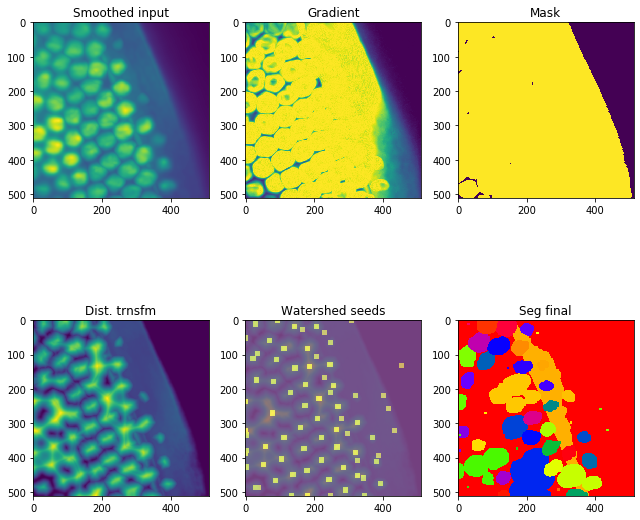

In [62]:
test = imp.segment_nuclei3D_2(stack[1,0], display=True, window_size=(70,45,45),size_min=0)

Interestingly the seeds seem mostly fine...but the watershed sucks? I wonder about doing the background subtraction on the gradient before watershed. This image is so packed...maybe the mean signal is pretty high and that's screwing it up. I removed that step and re-ran:

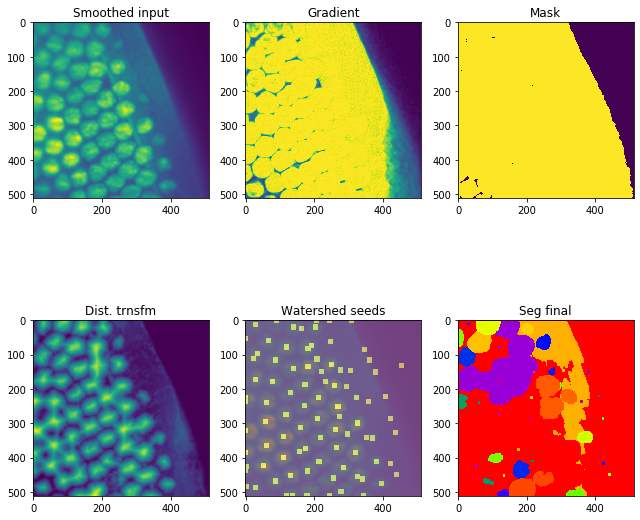

In [68]:
# tweaked seeds display to overlay stack not dist transform.
test = imp.segment_nuclei3D_2(stack[1,0], display=True, sigma=3, window_size=(70,45,45),size_min=0)

This is interesting. Looking at the above: the watershed seeding is pretty good, but the watershed segmentation sucks. Interestingly, seeding seems best with lower sigma (3), but segmentation looks a bit better with higher sigma. Going to play with the gradient filtering on this stack...

In [80]:
def grad(stack, sigma): 
    stack_smooth = ndi.filters.gaussian_filter(stack[1,0], sigma=sigma)

    # Take gradient separately for each dimension, combine as rootsumsquare to 
    # approximate 3D gradient.
    grad_z = ndi.filters.sobel(stack_smooth, axis=0)
    grad_i = ndi.filters.sobel(stack_smooth, axis=1)
    grad_j = ndi.filters.sobel(stack_smooth, axis=2)
    grad = np.sqrt((grad_z ** 2) + (grad_i ** 2) + (grad_j ** 2))
    return grad

b = []
for a in range(6,13):
    b.append(grad(stack, a))


In [81]:
viewer(b, 'zxy')


interactive(children=(Dropdown(description='Color', index=6, options=('inferno', 'plasma', 'Reds', 'gray_r', '…

Huh. Much more smoothing seems quite good. Will re-run original with lots of smoothing.

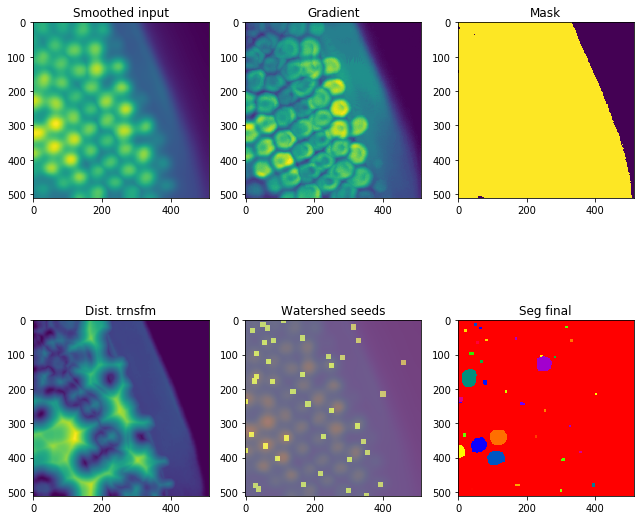

In [82]:
test = imp.segment_nuclei3D_2(stack[1,0], display=True, sigma=12, window_size=(70,45,45),size_min=0)

OK, so it looks like the above suspicion holds: less blurring yields better distance transforms (and seeding), more blurring better for watershedding. Implementing two sigmas...

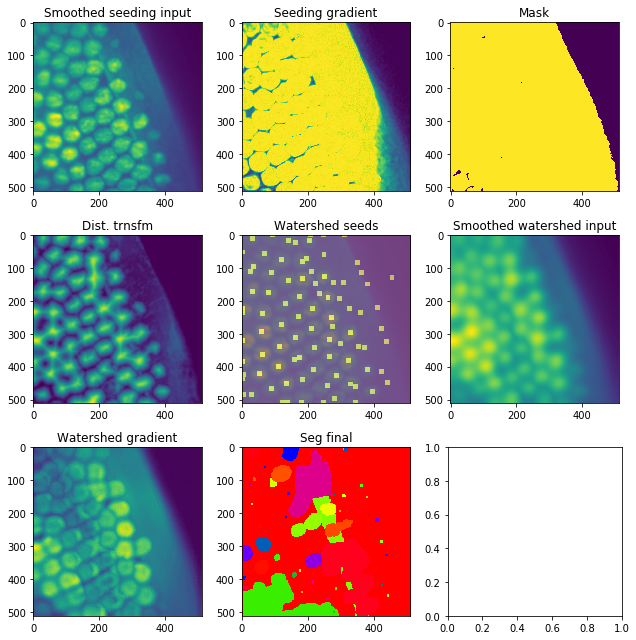

In [13]:
reload(imp);
test = imp.segment_nuclei3D_2(stack[1,0], display=True, sigma_seeding=3, sigma_watershed=15, window_size=(70,45,45),size_min=0)

So this still doesn't work super well. I got to thinking about difference of Gaussian (DoG) filters. I tried it out and it...almost perfectly gets nuclei on the initial mask. I worked this up:

In [42]:
from skimage.filters.thresholding import threshold_li
test = stack[1,0]
dog = ndi.filters.gaussian_filter(test, sigma=12) - ndi.filters.gaussian_filter(test, sigma=3)
t = threshold_li(dog)
mask = np.where(dog >= t, 1, 0)
mask = imp.imfill(mask, (0,0,100))
#mask = ndi.morphology.binary_opening(mask, structure=np.ones((1,5,5)))
#mask = ndi.morphology.binary_dilation(mask, structure=np.ones((1,7,7)))
labelmask, _ = ndi.label(mask)
#viewer([labelmask * 3,test],'zxy')

In [43]:
viewer(labelmask, 'zxy')

interactive(children=(Dropdown(description='Color', index=6, options=('Greens', 'prism', 'magma', 'plasma', 'i…

This is exceptionally good. There are like two nuclei that are merged, but even that is rare. I could add a gradient + distance transform + watershed step to solve this, but I think I might just wait. This seems damn good.
One thing I'd like to do is perform morphological operations on the label mask, a little hole-filling and dilation. I tried this followed by re-labeling, but sometimes the objects bumped into each other and got merged. So I wanted to come up with an approach where I did the morphological operation, then updated the new mask by assigning to each '1' pixel the label from the closest non-zero pixed in the original labelmask. This turned out to be non-trivial (it's possible by returning indexes from the distance transform, but the subsequent indexing is super slow and kept killing my kernel). 

I did a bunch of searching, and finally discovered that grayscale morphological operations basically just use maximum filters. This is a solution I had been thinking about. Anyway, I ended up writing the following function to perform morphological operations on labelmasks. The details are described in the docstring. It's not perfect, but it mostly gets the job done.

In [40]:
############################################################################
def labelmask_apply_morphology(labelmask, mfunc, struct=np.ones((2,2,2)), 
                               expand_size=(1,1,1), **kwargs):
    """Apply morphological functions to a labelmask.
    
    Args:
        labelmask: ndarray
            N-dimensional integer labelmask
        mfunc: python function
            Function from scikit.ndimage.morphology module
        struct: ndarray
            Structuring element for morpholocial operation
        expand_size: tuple of ints
            Size in N dimensions for maximum filter to produce label lookup
            mask (see details below)
        **kwargs: keyword arguments
            Keyword arguments supplied to morphological function
            
    Returns:
        new_labelmask: ndarray
            Updated labelmask matching shape of labelmask
    
    This is an imperfect solution to applying morphological operations to 
    labelmasks, so one needs to be a bit careful. The basic strategy is to
    binarize the mask, perform operations on it, and then from that mask 
    look up labels in the previous mask. This is better than re-labeling 
    because it allows the operations to produce objects that touch without 
    merging them. The issue is looking up the labels, which seems to be non-
    trivial. 
    
    The solution here is to generate a "lookup mask" by applying a maximum 
    filter (size determined by expand_size) to the labelmask, which expands 
    each object into its local area. As long as resulting morphological 
    operations keep the object within this area, they'll get the proper label. 
    As long as objects in the original image are spaced farther than the 
    supplied sizes in the three dimensions, this will work perfectly well. If 
    this isn't true, the object with the numerically larger label (arbitrary) 
    will expand at the expense of its neighbor. Of note, this maximum filter is 
    mathematially identical to morpholocial dilation when their is non conflict 
    between objects.
    
    For labelmasks with well-spaced objects, the function works as expected. 
    For closely spaced objects, one needs to select an expand_size that will
    generally be less than or equal to the object separation. For most
    applications, conflicts at edges won't be of great consequence but should
    be kept in mind.
    
    Suggested settings:
    
        -For operations that reduce the size of objects, leave expand_size 
        at (1,1,1), as resulting objects will be entirely contained within
        original objects.
        
        -For operations that increase the size of objects, set expand_size 
        to be equal to or slightly greater than expected increases in object
        size, and no more than the typical separation between objects.
        
    Examples:
    
    Dilation: 
        labelmask_apply_morphology(mylabelmask, ndi.morphology.binary_dilation,
        struct=np.ones((1,7,7)), expand_size=(1,8,8))
    
    Erosion:
       labelmask_apply_morphology(mylabelmask, ndi.morphology.binary_erosion,
        struct=np.ones((1,7,7))) 
        
    
    """
    # Expand the objects in the original mask to provide a "lookup" mask for
    # matching new objects to labels.
    lookupmask = ndi.maximum_filter(labelmask, expand_size)
    
    # Perform morphological operation on binarized labelmask.
    new_binmask = mfunc(labelmask, struct, **kwargs)
    
    # Match labels in new mask to those of lookup mask.
    new_labelmask = np.where(new_binmask, lookupmask, 0)
    return new_labelmask

a=labelmask_apply_morphology(labelmask, ndi.morphology.binary_dilation, struct=np.ones((1,10,10)), expand_size=(1,11,11))


In [66]:
def labelmask_filter_objsize(labelmask, size_min, size_max):
    (labels, counts) = np.unique(labelmask, return_counts=True)
    labels_selected = labels[(counts >= size_min) & (counts <= size_max)]
    labelmask_filtered = np.where(np.isin(labelmask, labels_selected), labelmask, 0)
    return labelmask_filtered



In [80]:
from skimage.filters.thresholding import threshold_li
def segment_nuclei3D_3(stack, sigma_big=12, sigma_small=3, dilation_length=7, size_min=1e4, size_max=5e5):
    dog = ndi.filters.gaussian_filter(test, sigma=12) - ndi.filters.gaussian_filter(test, sigma=3)
    t = threshold_li(dog)
    mask = np.where(dog >= t, 1, 0)
    mask = imp.imfill(mask, (0,0,100))
    #mask = ndi.morphology.binary_opening(mask, structure=np.ones((1,5,5)))
    #mask = ndi.morphology.binary_dilation(mask, structure=np.ones((1,7,7)))
    labelmask, _ = ndi.label(mask)
    labelmask = labelmask_apply_morphology(labelmask, ndi.morphology.binary_dilation, struct=np.ones((1, dilation_length, dilation_length)), expand_size=(1, dilation_length + 1, dilation_length + 1))
    labelmask = labelmask_filter_objsize(labelmask, size_min, size_max)
    return labelmask
    #viewer([labelmask * 3,test],'zxy')
labelmask = segment_nuclei3D_3(stack[1,0], size_max=3e5)

In [76]:
#a,c = np.unique(b, return_counts=True)
viewer(b, 'zxy')

interactive(children=(Dropdown(description='Color', index=6, options=('Greens', 'prism', 'magma', 'plasma', 'i…

This looks mostly great! I still got a little bit of embryo border in the first few Z slices. One way I've considered getting around that is implementing a measure for roundess. 

Find Z-slice with max pixels from object, determine i and j extent, take ratio, come up withe cutoff

In [116]:
# Write function to test "circularity" objects in a labelmask. 
# inputs: labelmask
from scipy.stats import mode

ratios = []

for x in np.unique(labelmask):
    z, i, j = np.where(labelmask == x)
    z_indexes = z == mode(z)[0][0]
    i_maxz = i[z_indexes]
    j_maxz = j[z_indexes]
    i_extent = i_maxz.max() - i_maxz.min()
    j_extent = j_maxz.max() - j_maxz.min()
    ratio = max(i_extent, j_extent) / min(i_extent, j_extent)
    ratios.append(ratio)


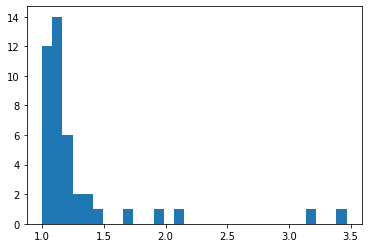

In [118]:
plt.hist(ratios, bins=30);

In [143]:
from scipy.stats import mode
from skimage.measure import label, regionprops


def object_circularity(labelmask, label):
    z, i, j = np.where(labelmask == label)
    zmax = mode(z)[0][0]
    im = np.where(labelmask[zmax] == label, 1, 0)
    regions = regionprops(im)
    perimeter = regions[0].perimeter
    area = len(z)
    circularity = 4 * np.pi * area / (perimeter ** 2) # formula used by imageJ
    return circularity
    

def filter_label_mask(labelmask, func, above=0, below=1e6):
    labels = []
    for x in np.unique(labelmask):
        prop = func(labelmask, x)
        if (prop >= above and prop <= below):
            labels.append(x)

    labelmask_filtered = np.where(np.isin(labelmask, labels), labelmask, 0)
    return labelmask_filtered

a = filter_label_mask(labelmask, object_circularity, above=5);

'''
for x in np.unique(labelmask):
    print(object_circularity(labelmask, x))
'''

'\nfor x in np.unique(labelmask):\n    print(object_circularity(labelmask, x))\n'

In [144]:
viewer([a, labelmask], 'zxy')

interactive(children=(Dropdown(description='Color', index=6, options=('Greens', 'prism', 'magma', 'plasma', 'i…

This seems to work great. I'm going to polish off the functions I want to keep:

In [106]:
from scipy.stats import mode
from skimage.measure import label, regionprops
from skimage.filters.thresholding import threshold_li

############################################################################
def labelmask_filter_objsize(labelmask, size_min, size_max):
    """Filter objects in a labelmask for size
    
    Args:
        labelmask: ndarray
            n-dimensional integer labelmask
        size_min: int
            Minimum size in total pixels, of the smallest object
        size_max: int
            Maximum size, in total pixels, of the largest object
    
    Return:
        labelmask_filtered: ndarray
            Labelmask of same shape as input mask, containing only objects
            between minimum and maximum sizes.
    """
    # Count pixels in each object.
    (labels, counts) = np.unique(labelmask, return_counts=True)
    # Select objects in desired size range, update filtered mask.
    labels_selected = labels[(counts >= size_min) & (counts <= size_max)]
    labelmask_filtered = np.where(np.isin(labelmask, labels_selected), 
        labelmask, 0)
    return labelmask_filtered

############################################################################
def object_circularity(labelmask, label):
    """Calculate circularity for and object in a labelmask
    
    Implements imageJ circularity measure: 4pi(Area)/(Perimeter^2).
    
    Args:
        labelmask: ndarray
            n-dimensional integer labelmask
        label: int
            ID of object for which to calculate circularity
            
    Return:
        circularity: float
            output of circularity calculation 
    """
    # Find z slice with most pixels from object.
    z, i, j = np.where(labelmask == label)
    zmax = mode(z)[0][0]
    # Select 2D image representing object's max Z-slice.
    im = np.where(labelmask[zmax] == label, 1, 0)
    # Calculate circularity from object perimeter and area.
    regions = regionprops(im)
    perimeter = regions[0].perimeter
    area = len(z)
    circularity = 4 * np.pi * area / (perimeter ** 2) 
    return circularity
    
############################################################################
def filter_labelmask(labelmask, func, above=0, below=1e6):
    """Filter objects from a labelmask based on object properties
    
    Applies a user-supplied function that returns a numeric value for an
    object in a labelmask, filters mask to contain only objects between
    minimum and maximum values.
    
    Args:
        labelmask: ndarray
            n-dimensional integer labelmask
        func: function
            Function that accepts a labelmask as its first argument, object
            ID as second argument, and returns a numeric value.
        above: numeric
            Lower limit for object's value returned from the function.
        below: numeric
            Upper limit for object's value returned from the function.
            
    Return:
        labelmask_filtered: ndarray
            Labelmask of same shape as input mask, containing only objects
            between minimum and maximum values from supplied function.
    """
    labels = []
    for x in np.unique(labelmask):
        prop = func(labelmask, x)
        if (prop >= above and prop <= below):
            labels.append(x)
    labelmask_filtered = np.where(np.isin(labelmask, labels), labelmask, 0)
    return labelmask_filtered

############################################################################
def segment_nuclei3D_3(instack, sigma_big=17, sigma_small=3, erosion_length=10, dilation_length=10, 
                       size_min=1e4, size_max=7.5e5, circularity_min=10):
    """Segment nuclei from a 3D imaging stack
   
    Args:
        stack: ndarray
            3D image stack of dimensions [z, x, y].
        sigma_big: int
            Sigma for larger Gaussian filter
        sigma_small: int
            Sigma for smaller Gaussian filter
        dilation_length: int
            Size in x and y of structuring element for dilating objects
        size_min: int
            Minimum size, in pixels, of objects to retain
        size_max: int
            Maximum size, in pixels, of objects to retain
        circularity_min: float
            Minimum circularity measure of objects to retain
    
    Returns:
        labelmask: ndarray
            Mask of same shape as input stack with nuclei segmented and labeled
    
    """
    # Normalize each Z-slice to mean intensity to account for uneven illumination.
    stack = mean_normalize_stack(instack)
    # Apply difference of gaussians filter.
    dog = ndi.filters.gaussian_filter(stack, sigma=sigma_big) - ndi.filters.gaussian_filter(stack, sigma=sigma_small)
    # Threshold, make binary mask, fill.
    t = threshold_li(dog)
    mask = np.where(dog >= t, 1, 0)
    mask = imp.imfill(mask, (0,0,100))
    # Use morphological erosion to remove spurious connections between objects.
    mask = ndi.morphology.binary_erosion(mask, structure=np.ones((1, erosion_length, erosion_length)))
    return mask
    # Label objects in binary mask.
    labelmask, _ = ndi.label(mask)
    # Dilate labelmask to compensate for earlier erosion.
    labelmask = labelmask_apply_morphology(labelmask, 
            mfunc=ndi.morphology.binary_dilation, 
            struct=np.ones((1, dilation_length, dilation_length)), 
            expand_size=(1, dilation_length + 1, dilation_length + 1))
    # Filter nuclei for size and circularity.
    labelmask = labelmask_filter_objsize(labelmask, size_min, size_max)
    labelmask = filter_labelmask(labelmask, object_circularity, circularity_min, 1000)
    return labelmask

In [62]:
reload(imp)
labelmask = segment_nuclei3D_3(stack[1,0], size_max=1e7, circularity_min=5, sigma_big=17, sigma_small=3)

In [107]:
#viewer([np.where(a, stack[1,0], 0), stack[1,0]], 'zxy')
viewer([stack[1,0],np.where(labelmask, stack[1,0], 0)], 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

This looks pretty excellent. Let's try it on a couple other stacks.

In [56]:
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em1_mv2/',
    span=(30,33))


In [67]:
labelmask = segment_nuclei3D_3(stack[1,0], size_min=500, size_max=1e7, circularity_min=0, sigma_big=17, sigma_small=3)

In [70]:
viewer([stack[1,0],np.where(labelmask, stack[1,0], 0)], 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

20171207_Zldeve_em1_mv1 worked well, but for 20171207_Zldeve_em1_mv2 I get some nuclei that drop out. It turns out that on the lower Z slies, most of the frame is above threshold. This is because these slices have higher background, part of lattice illumination variance:

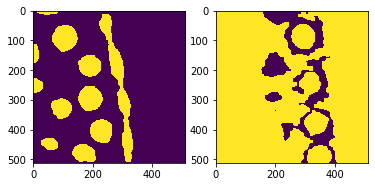

In [76]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(labelmask[10].astype('bool'))
ax[1].imshow(labelmask[50].astype('bool'))

Let's try equalizing signal between Z slices.

In [138]:
def zstack_normalize_mean(instack):
    stack = np.copy(instack)    
    stackmean = stack.mean()
    for x in range(0,stack.shape[0]):
        immean = stack[x].mean()
        stack[x] = stack[x] / immean * stackmean
    return(stack)

#plt.imshow(mean_normalize_image(stack[1,0]))
#a=mean_normalize_stack(stack[1,0])

In [97]:
viewer(a, 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

This worked. I updated the segmentation function to add a normalization step. Let's see if it cleans things up. It did...not. Still missing hte last nuclei. I then took a look at the mask:

In [108]:
# Returned mask from 3d segmentation
mask = segment_nuclei3D_3(stack[1,0], size_max=6e5, circularity_min=10, sigma_big=17, sigma_small=3)
viewer([stack[1,0],np.where(labelmask, stack[1,0], 0)], 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

The problem is that the nuclei are touching the embryo boundary, get collapsed to a single object, and consequently fail circularity and size cutoffs. Sign. The boundary is a perpetual problem...and these nuclei are literally touching the boundary in the original stack. Sigh. What if I just crank the erosion?

In [111]:
# Returned mask from 3d segmentation
mask = segment_nuclei3D_3(stack[1,0], size_max=6e5, circularity_min=10, sigma_big=17, sigma_small=3, erosion_length=20, dilation_length=20)
viewer([stack[1,0],np.where(mask, stack[1,0], 0)], 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

Erosion doesn't solve our problem. I updated the segment_nuclei3D_3 function in the module to reflect the changes and added mean_normalize_stack. I'm going to revisit embryo segmentation (aiming to get rid of embryo boundary). Starting with the function I wrote previously.

In [186]:
import skimage as ski
############################################################################
def segment_embryo(stack, channel=0, sigma=5, walkback = 50):
    """Segment the embryo from extra-embryo space in lattice data.
    
    Details: Crudely segments the embryo from extra-embryonic space in 5-
    dimensional stacks. Performs a gaussian smoothing, then thresholds,
    then uses morphological filtering to fill holes and then to "walk
    back" from right-to-left, based on the observation that segementation 
    tends to extend too far, and lattice images always have the sample on
    the left.
    
    Args:
        stack: ndarray
            Image stack in order [c, t, z, x, y]
        channel: int
            Channel to use for segmentation (channel definted as first
            dimension of the stack)
        sigma: int
            Sigma factor for gaussian smoothing
        walkback: int
            Length in pixels to "walk back" from right
            
    Returns:
        stack_masked: ndarray
            Input stack with masked (extra-embryo) positions set to 0
    """
    # Create a 3D mask from the mean projection of a 4D stack.
    def _make_mask(stack, channel, sigma, walkback):
        # Make a mean projection (on time axis) for desired channel. 
        im = stack[channel].mean(axis=0)
        # Smooth with gaussian kernel.
        im_smooth = ndi.filters.gaussian_filter(im, sigma=sigma)
        im_smooth = zstack_normalize_mean(im_smooth)
        return im_smooth
        # Find threshold with minimum method.
        t = ski.filters.threshold_minimum(im_smooth)
        # Make binary mask with threshold.
        mask = np.where(im_smooth > t, 1, 0)
        # Fill holes with morphological processing.
        mask = ndi.morphology.binary_fill_holes(mask, structure=np.ones((1,5,5)))
        # Build structure for "walking back" from right via morphological processing.
        struc = np.ones((1,1, walkback))
        midpoint = int(walkback / 2)
        struc[0, 0, 0:midpoint] = 0
        # Walk back mask from right.
        mask = ndi.morphology.binary_erosion(mask, structure=struc)
    
    def main(stack, channel, sigma, walkback):
        mask = _make_mask(stack, channel, sigma, walkback)
        stack_masked = np.where(mask, stack, 0) # Broadcasting mask onto stack
        return(stack_masked)
    
    return main(stack, channel, sigma, walkback)

def dog_filter(stack, sigma_big, sigma_small):
    return ndi.filters.gaussian_filter(stack, sigma=sigma_big) - ndi.filters.gaussian_filter(stack, sigma=sigma_small)

In [163]:
from skimage.filters.thresholding import threshold_otsu
im = stack[0].max(axis=0)
im = zstack_normalize_mean(im)
im1 = ndi.filters.median_filter(im, (1,5,5))
im2 = dog_filter(im1,3,2)
t = threshold_li(im2)
mask = np.where(im2 >= t, 1, 0)
mask2 = ndi.morphology.binary_opening(mask, structure=np.ones((1,20,20)))
#mask2 = ndi.morphology.binary_closing(mask, structure=np.ones((1,5,5)))

In [166]:
im = stack[0].max(axis=0)
im = zstack_normalize_mean(im)
viewer(im, 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

This is frustrating. I hate all these functions. How about this: two observations: 1) The mean signal in the embryo is higher than the mean signal outside. 2) We have a  strong prior (and can just require) about parts of the image that are background and embryo. Top right is background, bottom left is embryo.

So:

1. Mean or some other projection (in t)
2. Normalize Z slices
3. Smooth (gaussian or mean filter).
3. Threshold using information from embryo slice in bottom left and background slice in top right.

In [170]:
im = stack[0].max(axis=0)
im = zstack_normalize_mean(im)
im1 = ndi.filters.median_filter(im, (1,15,15))

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

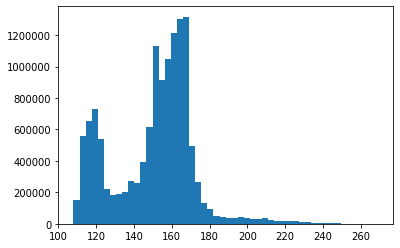

In [174]:
plt.hist(im1.flatten(), bins=50);

In [178]:
im1[0,:,-40:].mean()
im1[50,:,:40].mean()

120.126123046875

162.260205078125

In [184]:
viewer(np.where(im1 >= 140,im,0), 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

That doesn't work much better. Hmmmmm. So problems:
1. The border itself is highly variable between experiments and between Z-slices. So segmenting by detecting the border directly is pretty hard or impossible.
2. Lower stacks (have to pass through lots of embryo) are particularly janky and sometimes have very similar intensities inside and outside the embryo (hard for me to actually "see" rather than infer where the edge is).

Let me return to my  original segment_embryo function for a moment.

In [188]:
viewer(imp.segment_embryo(stack), 'ctzxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

This does pretty well, but critically misses the bright border. Grrr.

OK, how about the observation that the border typically shows up in both channels? Can we just look for low-frequency features that are present in both channels, removing them on the assumption that such features are definitionally background?

In [190]:
c0 = stack[0].mean(axis=0)
c1 = stack[1].mean(axis=0)

In [203]:
#dog1 = ndi.filters.gaussian_filter(stack[1,0], 17) - ndi.filters.gaussian_filter(stack[1,0], 3)
#dog1 = dog_filter(c1, 17,3)
viewer([c0], 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

In [207]:
c0_smooth = ndi.filters.gaussian_filter(c0, 3)
c1_smooth = ndi.filters.gaussian_filter(c1, 3)
c0_smooth_norm = zstack_normalize_mean(c0_smooth)
c1_smooth_norm = zstack_normalize_mean(c1_smooth)
t0 = threshold_otsu(c0_smooth_norm)
t1 = threshold_li(c1_smooth_norm)
c0_mask = np.where(c0_smooth_norm >= t0, 1, 0)
c1_mask = np.where(c1_smooth_norm >= t0, 1, 0)

viewer([c0_mask, c1_mask], 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

This thresholding approach actually just (mostly) segmented the embryo. It occurs to me that what I really want is to use the same procedure I use for segementing nuclei, up to the point of making a mask. Do that procedure for both channels, remove regions that are foregound in both masks. I guess this really means just running the red channel through the algorithm up to mask. I'll add a mask as an optional argument to the 3D segmenter.

In [219]:
def test(instack, sigma_big=17, sigma_small=6, erosion_length=10):    
    stack = zstack_normalize_mean(instack)
    # Apply difference of gaussians filter.
    dog = ndi.filters.gaussian_filter(stack, sigma=sigma_big) - ndi.filters.gaussian_filter(stack, sigma=sigma_small)
    # Threshold, make binary mask, fill.
    t = threshold_li(dog)
    mask = np.where(dog >= t, 1, 0)
    mask = imp.imfill(mask, (0,0,100))
    # Use morphological erosion to remove spurious connections between objects.
    mask = ndi.morphology.binary_erosion(mask, structure=np.ones((1, erosion_length, erosion_length)))
    return mask

red = test(stack[0,0])

In [220]:
green = test(stack[1,0])

In [211]:
viewer([red, green], 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

In [221]:
sub = np.where((red == 0) | (green == 0), green, 0)

In [222]:
viewer([stack[0,0], sub*200],'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

Wow. This works extremely well...There's a bit of an issue with harmonizing thresholding but that can be solved. Now going to write a function to generate a mask of shared low frequency features. 

In [254]:
from skimage.filters.thresholding import threshold_minimum, threshold_triangle
############################################################################
def mask_background(instack, channel_ref=1, channel_control=0, zslice=0, sigma_big=17, sigma_small=6, erosion_length=3):    
    def normdog(instack, channel, sigma_big, sigma_small, zslice):
        # Normalize across Z slices.
        stack = zstack_normalize_mean(instack[channel, zslice])
        # Apply difference of gaussians filter.
        dog = ndi.filters.gaussian_filter(stack, sigma=sigma_big) - ndi.filters.gaussian_filter(stack, sigma=sigma_small)
        return dog
    
    def mask_makefill(dog, t, erosion_length):
        mask = np.where(dog >= t, 1, 0)
        mask = imp.imfill(mask, (0,0,100))
        # Use morphological erosion to remove spurious connections between objects.
        mask = ndi.morphology.binary_erosion(mask, structure=np.ones((1, erosion_length, erosion_length)))
        return mask
    
    refdog = normdog(instack, channel_ref, sigma_big, sigma_small, zslice)
    contdog = normdog(instack, channel_control, sigma_big, sigma_small, zslice)
    
    # Threshold, make binary mask, fill.
    percentile=80
    t = np.percentile(contdog, percentile);
    
    refmask = mask_makefill(refdog, t, erosion_length)
    contmask = mask_makefill(contdog, t, erosion_length)
    #return refmask
    mask_intersect = np.where((refmask == 1) & (contmask == 1), 1, 0)
    return mask_intersect

test = mask_background(stack)

In [255]:
viewer([np.where(test, stack[1,0],0),test*255], 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

I'm having trouble getting this right. Thresholding is giving weird results. Maybe dog is the wrong way to go...maybe we just do a gentle smoothing, threshold, and remove?

In [298]:
from skimage.filters.thresholding import threshold_minimum, threshold_triangle, threshold_otsu
############################################################################
def mask_background(instack, channel_ref=1, channel_control=0, zslice=0, sigma=3, percentile=95):    
    
    def normdog(instack, channel, sigma, zslice):
        # Normalize across Z slices.
        stack = zstack_normalize_mean(instack[channel, zslice])
        # Apply difference of gaussians filter.
        dog = ndi.filters.gaussian_filter(stack, sigma=sigma)
        return dog
    
    def mask_makefill(dog, percentile):
        t = np.percentile(dog, percentile);
        mask = np.where(dog >= t, 1, 0)
        mask = imp.imfill(mask, (0,0,100))
        # Use morphological erosion to remove spurious connections between objects.
        mask = ndi.morphology.binary_closing(mask, structure=np.ones((1, 3, 3)))
        mask = ndi.morphology.binary_opening(mask, structure=np.ones((1, 12, 12)))
        return mask
    
    refdog = normdog(instack, channel_ref, sigma, zslice)
    contdog = normdog(instack, channel_control, sigma, zslice)
    
    # Threshold, make binary mask, fill.
    
    
    refmask = mask_makefill(refdog, percentile)
    contmask = mask_makefill(contdog, percentile)
    #return np.where(contmask > t, 1, 0)
    return contmask
    mask_intersect = np.where((refmask == 1) & (contmask == 1), 1, 0)
    return mask_intersect

test = mask_background(stack, sigma=3, percentile=97)

In [299]:
viewer(test, 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

Yeah this works well. New plan: just use the red channel to identify bright background features. It won't be general, but it will work for this data. Use the above function on the red channel (tuning percentile threshold) to find borders. This will work.

One last idea...what about just using a blurred red channel as a background for background subtraction?

In [331]:
red = stack[0].mean(axis=0)
#red = ndi.filters.gaussian_filter(red, sigma=3)
green = stack[1,0]

In [333]:
scale = green.mean() / red.mean() * 1
#scale = 2
bgsub = green - (scale*red)
bgsub = bgsub + abs(bgsub.min())
viewer(bgsub, 'zxy')


interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

WOW. This works spectacularly well. I think I should be able to combine this "subtraction of background" from the red channel prior to the 3rd segmentation routine. I tried this out and something funny happened. Here is the dog transform (17, 3) of the background (red channel) subtracted image:

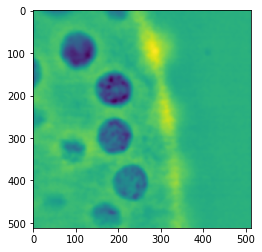

In [356]:
plt.imshow(b[15])

This has somehow gotten inverted. What is happening? I think that the background subtraction is mathematically similar to subtracting a smoothed image, so we've got something like a multiple gaussian subtractions. Let's look at the individual gaussian smoothings of the background subtracted images:

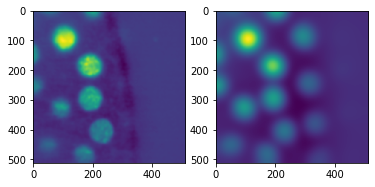

In [372]:
bgs3 = ndi.filters.gaussian_filter(bgsub, sigma=3);
bgs17 = ndi.filters.gaussian_filter(bgsub, sigma=17);
fig, ax = plt.subplots(1,2)
ax[0].imshow(bgs3[15])
ax[1].imshow(bgs17[15])

Now let's do it for the unsubtracted image:

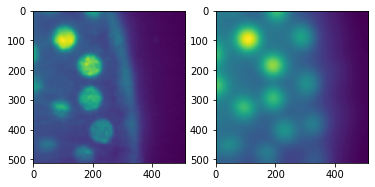

In [373]:
s3 = ndi.filters.gaussian_filter(stack[1,0], sigma=3);
s17 = ndi.filters.gaussian_filter(stack[1,0], sigma=17);
fig, ax = plt.subplots(1,2)
ax[0].imshow(s3[15])
ax[1].imshow(s17[15])

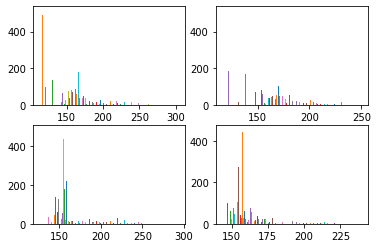

In [365]:
fig, ax = plt.subplots(2,2)
ax[0][0].hist(s3[15], bins=40);
ax[0][1].hist(s17[15], bins=40);
ax[1][0].hist(bgs3[15], bins=40);
ax[1][1].hist(bgs17[15], bins=40);

Not very illuminating. I wish I understood the math better...Basically as implemented it's something like subtracting a blurred image (prob low sigma), then taking the different of convolving that smoothed image with a large and small gaussian. Somehow the math works out to invert it...

Either way, it seems that the dog filter is completely unnecessary. A simple gaussian blur of the background subtracted image seems perfectly sufficient. Here are the two functions together:

In [397]:
def segment_nuclei3D_3(instack, sigma_big=17, sigma_small=3, erosion_length=10, dilation_length=10, 
                       size_min=1e4, size_max=7.5e5, circularity_min=10):
    """Segment nuclei from a 3D imaging stack
   
    Args:
        stack: ndarray
            3D image stack of dimensions [z, x, y].
        sigma_big: int
            Sigma for larger Gaussian filter
        sigma_small: int
            Sigma for smaller Gaussian filter
        dilation_length: int
            Size in x and y of structuring element for dilating objects
        size_min: int
            Minimum size, in pixels, of objects to retain
        size_max: int
            Maximum size, in pixels, of objects to retain
        circularity_min: float
            Minimum circularity measure of objects to retain
    
    Returns:
        labelmask: ndarray
            Mask of same shape as input stack with nuclei segmented and labeled
    
    """
    # Normalize each Z-slice to mean intensity to account for uneven illumination.
    stack = zstack_normalize_mean(instack)
    # Apply difference of gaussians filter.
    #dog = ndi.filters.gaussian_filter(stack, sigma=sigma_big) - ndi.filters.gaussian_filter(stack, sigma=sigma_small)
    dog = ndi.filters.gaussian_filter(stack, sigma=sigma_small)
    # Threshold, make binary mask, fill.
    t = threshold_otsu(dog)
    mask = np.where(dog >= t, 1, 0)
    mask = imp.imfill(mask, (0,0,100))
    # Use morphological erosion to remove spurious connections between objects.
    mask = ndi.morphology.binary_erosion(mask, structure=np.ones((1, erosion_length, erosion_length)))
    return mask
    # Label objects in binary mask.
    labelmask, _ = ndi.label(mask)
    # Dilate labelmask to compensate for earlier erosion.
    labelmask = labelmask_apply_morphology(labelmask, 
            mfunc=ndi.morphology.binary_dilation, 
            struct=np.ones((1, dilation_length, dilation_length)), 
            expand_size=(1, dilation_length + 1, dilation_length + 1))
    # Filter nuclei for size and circularity.
    labelmask = labelmask_filter_objsize(labelmask, size_min, size_max)
    labelmask = filter_labelmask(labelmask, object_circularity, circularity_min, 1000)
    return labelmask

def stack_bgsub(stack, bgchannel=0, fgchannel=1):
    bg = stack[bgchannel].mean(axis=0)
    scale = stack[fgchannel].mean() / bg.mean()
    bgsub = stack - (scale * bg)
    bgsub = bgsub + abs(bgsub.min())
    return bgsub


In [375]:
stackb = stack_bgsub(stack)

In [376]:
b = segment_nuclei3D_3(stackb[1,0])

In [378]:
viewer([stack[1,0],b*30], 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

Absolutely spectacular. Let's try with a few other stacks.

In [ ]:
stack_1 = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em5_mv2/',
    span=(0,8))

In [400]:
#stackb1 = stack_bgsub(stack_1)
b1 = segment_nuclei3D_3(stackb1[1,0], sigma_small=2, erosion_length=10)
#viewer([stack[1,0],b1*30], 'zxy')
viewer(b1, 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'gray_r', 'plasma', 'inferno'…

It's having troubles with connected nuclei. Nothing that watershed won't solve! These masks look ideal for watershedding. I'm goign to start a new notebook because this one is bloated to hell. Going to pick up right here...